In [2]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## Validating the GTFS stops and CIS data in directions

### Comparing the the frequency of stop sequences of GTFS data in hours 6-25 and CIS data in hours 0-23

There are four heat maps outputted, which indicate the distributions of GTFS data and CIS data of each stop_sequence in hours in different directions.

In [33]:
sql_GTFS_1 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df1 = pandasql.read_sql(sql_GTFS_1, con)

df1 = df1.pivot("hours", "stop_sequence", "schedule")

In [34]:
sql_GTFS_0 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2 = pandasql.read_sql(sql_GTFS_0, con)

df2 = df2.pivot("hours", "stop_sequence", "schedule")

In [35]:
sql_cis_1 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691042
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df3 = pandasql.read_sql(sql_cis_1, con)

df3 = df3.pivot("hours", "stop_sequence", "cis_data")

In [36]:
sql_cis_0 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691040
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df4 = pandasql.read_sql(sql_cis_0, con)

df4 = df4.pivot("hours", "stop_sequence", "cis_data")

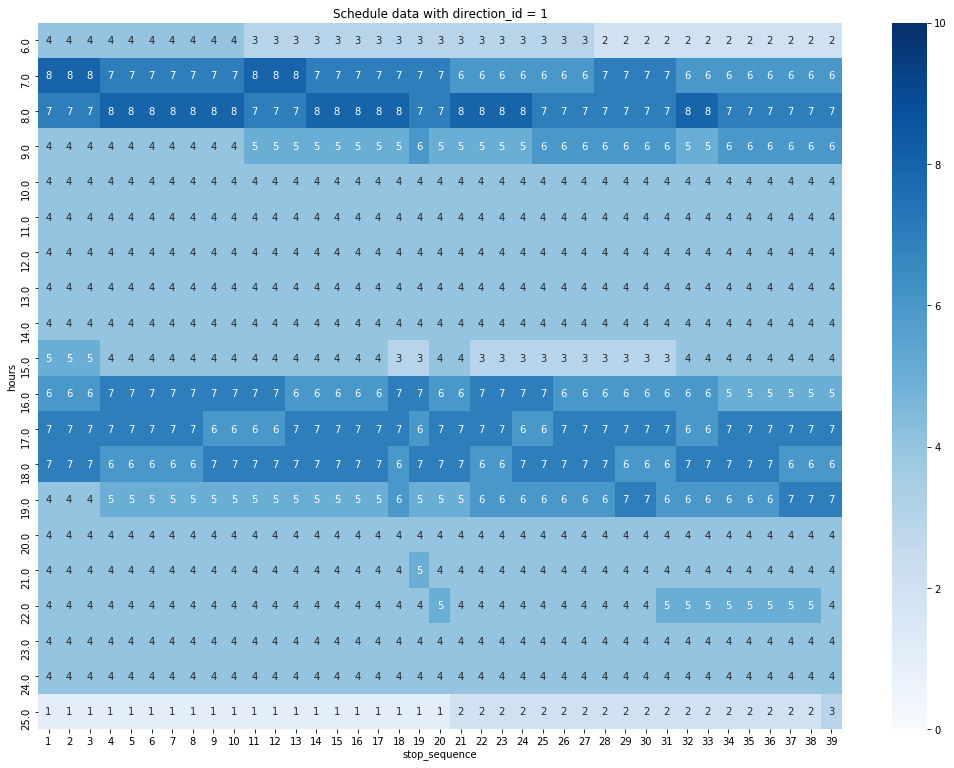

In [42]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('Schedule data with direction_id = 1')
sns.heatmap(df1, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

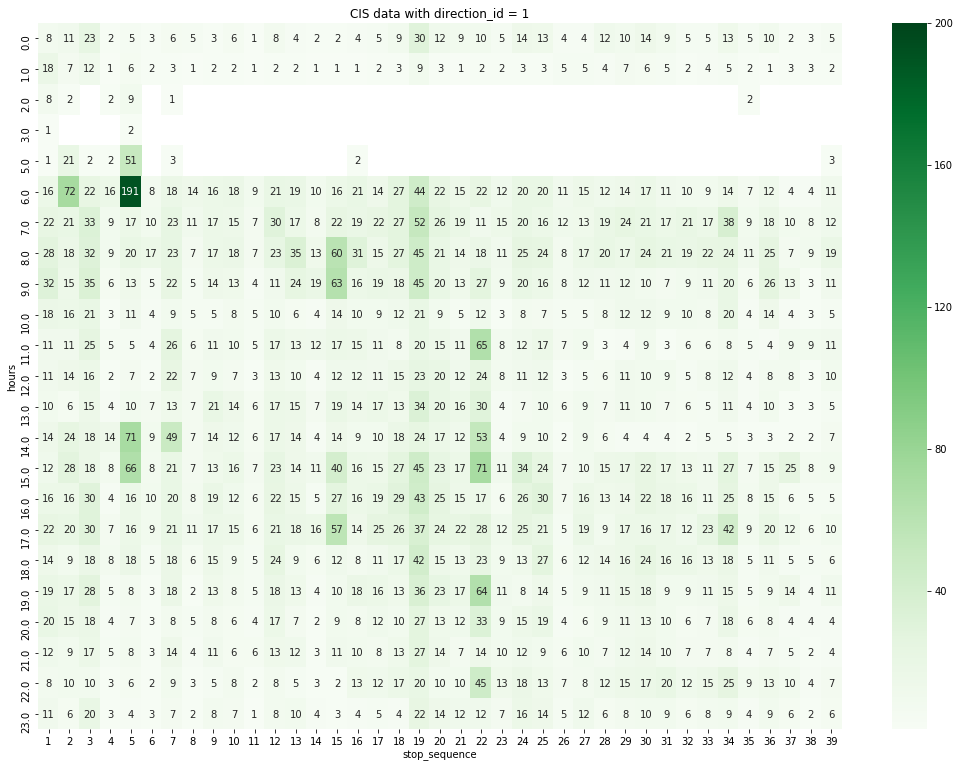

In [43]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS data with direction_id = 1')
sns.heatmap(df3, vmin=1, vmax=200,cmap = 'Greens', annot=True, fmt='g')

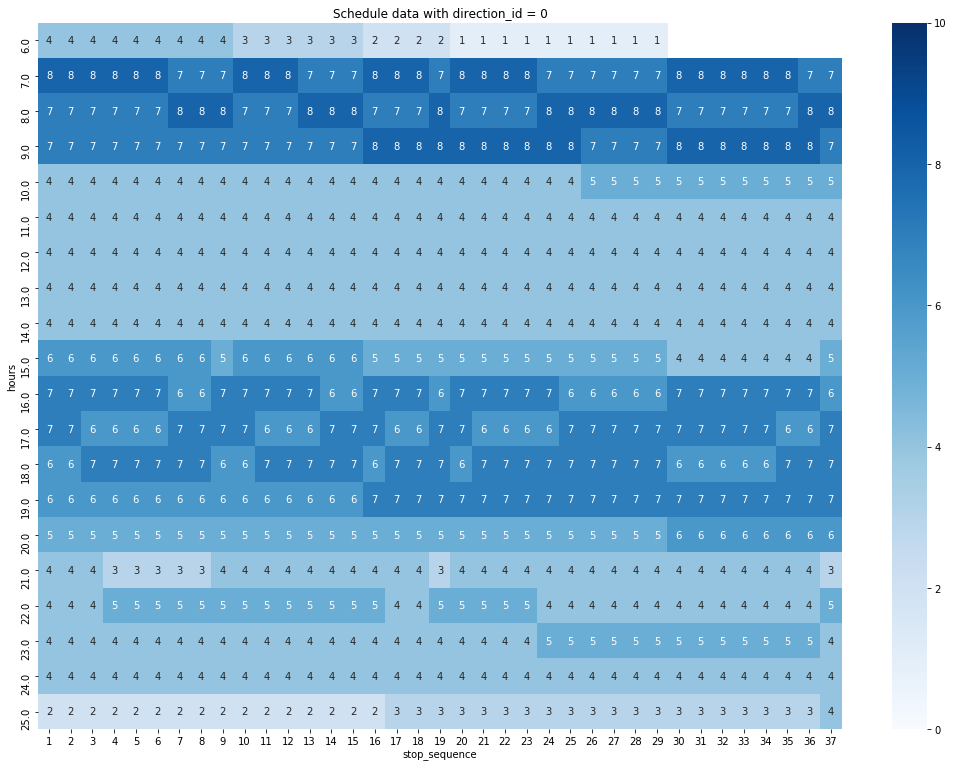

In [44]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('Schedule data with direction_id = 0')
sns.heatmap(df2, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

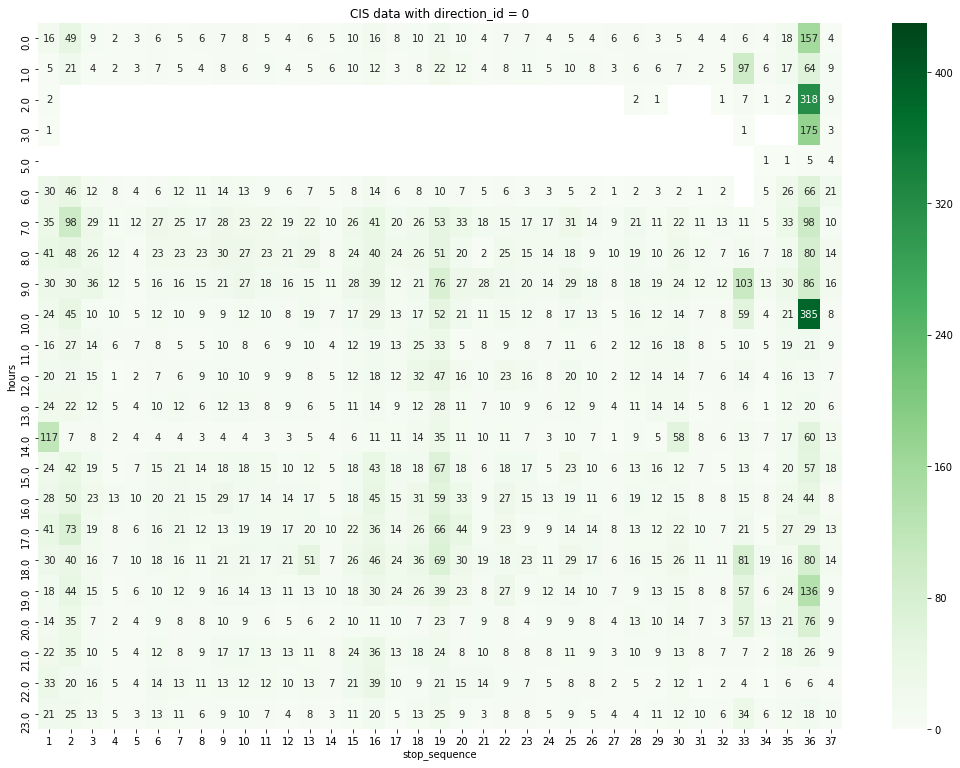

In [41]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS data with direction_id = 0')
sns.heatmap(df4, vmin=0, vmax=430,cmap = 'Greens', annot=True, fmt='g')

### Validating and Comparing the numbers of GTFS data and CIS data in different stop sequences in a day.

#### The heat maps represent the difference between the count of GTFS schedule service and the count of CIS data with the same stop sequence in hours in the direction of 0 and 1.

In [35]:
sql_compare_1 = '''
WITH gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_sequence, count(*) AS GTFS_count
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042
GROUP BY hours, stop_sequence
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, sum(array_length(cis_id, 1)) AS cis_count
FROM match_stop_514
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042 
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count
FROM cis_data
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences, 
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) AS gtfs_count, 
(CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS cis_count,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff
ORDER BY time_hours, stop_sequences
'''

df5 = pandasql.read_sql(sql_compare_1, con)

df5 = df5.pivot("time_hours", "stop_sequences", "diff")

In [37]:
sql_compare_0 = '''
WITH gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_sequence, count(*) AS GTFS_count
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040
GROUP BY hours, stop_sequence
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, sum(array_length(cis_id, 1)) AS cis_count
FROM match_stop_514
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count
FROM cis_data
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences, 
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff
ORDER BY time_hours, stop_sequences
'''

df6 = pandasql.read_sql(sql_compare_0, con)

df6 = df6.pivot("time_hours", "stop_sequences", "diff")

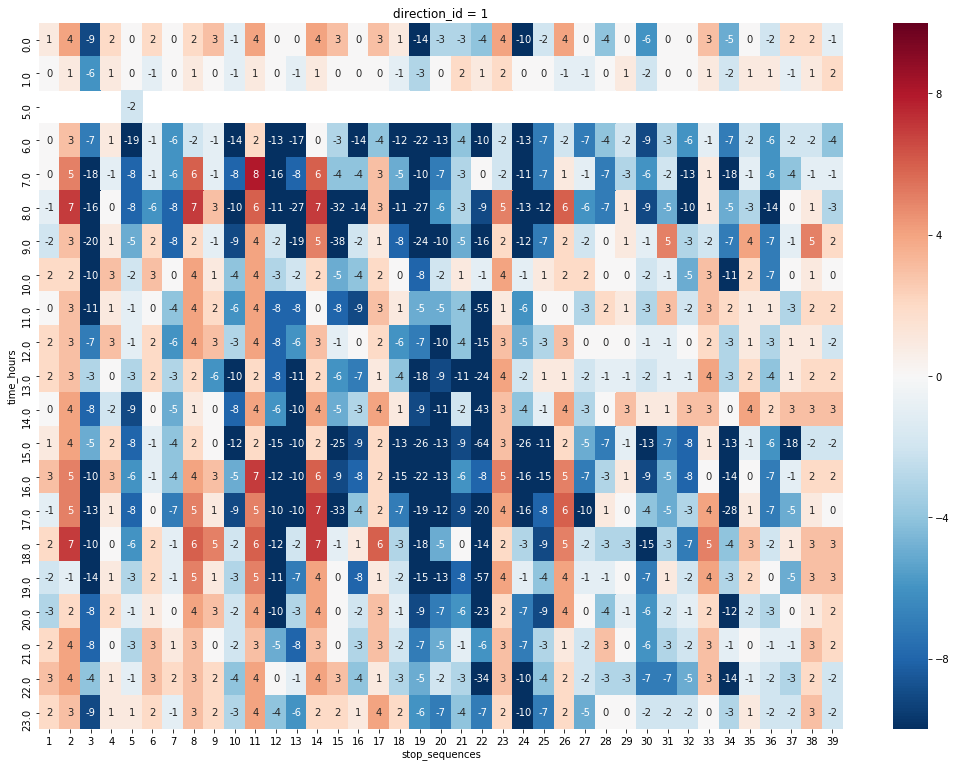

In [39]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('direction_id = 1')
sns.heatmap(df5, vmin=-10, vmax=10, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

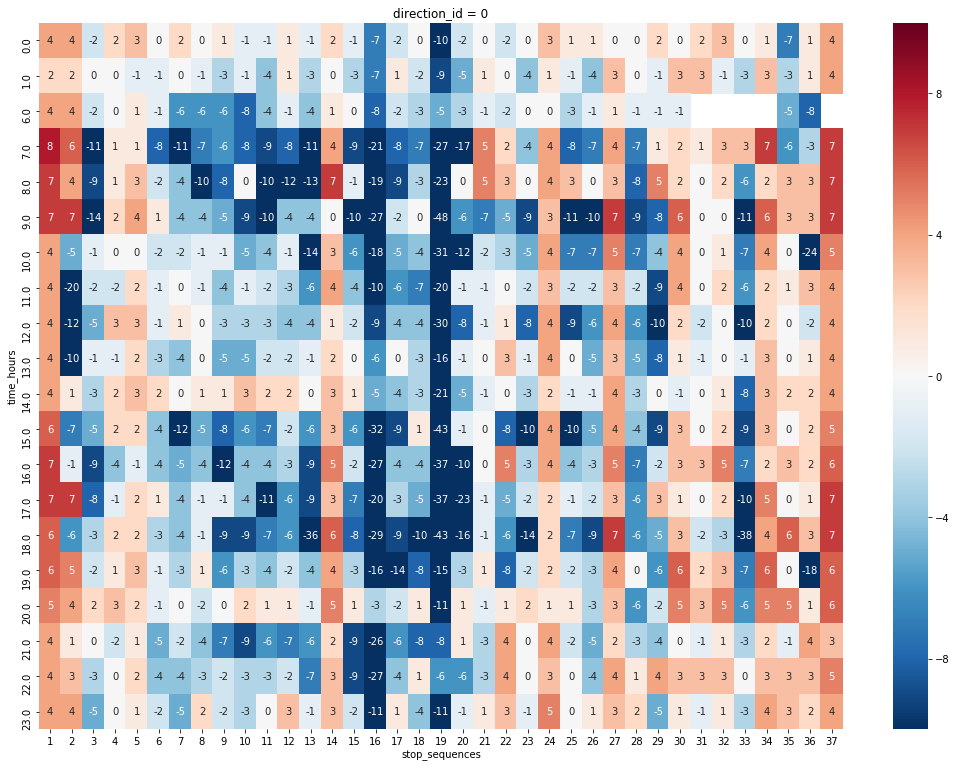

In [38]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('direction_id = 0')
sns.heatmap(df6, vmin=-10, vmax=10, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

**Any null cell from the heat maps indicates that there is not either GTFS data or CIS data in the hour with the stop_sequence.**

Vertical: 


direction = 1:

1. The large differences between schedule service (GTFS data) and the real-time record (CIS data) concentrate at the stop_sequence number of 3, 12, 13, 19, 20, 22, 24, 34
2. The large positive differences concentrate at stop_sequence number of 2, 8, 11, 14
3. The small differences concentrate at stop_sequence number of 4, 29

direction = 0:

1. The large negative differences concentrate at stop_sequence number of 2, 13, 16, 19, 20, 33
2. The large positive differences concentrate at stop_sequence number of 1, 2, 14, 27, 34, 37
3. The small differences concentrate at stop_sequence number of 4, 5, 31

Both directions:

-  Common large negative differences concentrate at stop_sequence number of 13, 19, 20
-  Common small differences concentrate at stop_sequence number of 4
 <br>

***
Horizontal:


direction = 1:

1. There are two cis data records at 5 with stop_sequence equals to 5; however, there is not other GTFS data or CIS data in that hour except them. (reason unknown)
2. The large negative differences concentrate at hour of 6, 8, 15, 16, 17
3. The large positive differences concentrate at hour of 7, 8, 16, 17, 18
4. The small differences concentrate at hour of 1, 23


-  Common differences concentrate at hour of 8, 16, 17


direction = 0:

1. The large negative differences concentrate at hour of 7, 8, 9, 16, 17, 18, 19
2. The large positive differences concentrate at hour of 7, 8, 9, 16, 17, 18, 19
3. The small differences concentrate at hour of 1, 6, 20


-  Common differences concentrate at hour of 7, 8, 9, 16, 17, 18, 19


Both directions:

-  Common large negative differences concentrate at hour of 8, 17 (rushing hours)
-  Common large positive differences concentrate at hour of 7, 8, 16, 17, 18 (rushing hours)
-  Common large differences concentrate at hour of 8, 17 (rushing hours)
-  Common small differences concentrate at hour of 1


![validating1](gtfs/img/validating_1.png)

These are the examples of cis_data with the stop_sequence of 19. 20, 22, 24, and they have "large difference" in the heat map (direction = 1). Based on the map, the data points can be messy or linear.

![validating2](gtfs/img/validating_2.png)

If we compare two cis data sets, which are having "small differences" (good) and "large differences" (bad), they both are linear.

So we can't indicate the if the cis_data sets are good or bad based on their shapes